# 模型可视化：使用R的glmnet包进行LASSO回归

本笔记本通过subprocess调用R的glmnet包，生成专业的LASSO回归可视化图表

## 功能
1. **交叉验证偏差图**：展示不同λ值下的模型性能
2. **系数路径图**：展示特征系数随λ变化的轨迹
3. **特征选择结果**：识别最重要的预测特征
4. **模型性能评估**：在验证集上的AUC、准确率等指标

In [40]:
import os
import pandas as pd
import numpy as np
import warnings
import subprocess

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# R可执行文件路径
R_EXE = r"D:\Program Files\R\R-4.4.3\bin\x64\Rscript.exe"

# 验证R是否可用
try:
    result = subprocess.run(
        [R_EXE, "--version"], capture_output=True, text=True, timeout=10
    )
    print(f"R版本信息:\n{result.stdout.split(chr(10))[0]}")
    print(f"\nR路径: {R_EXE}")
    print("R环境验证成功！")
except Exception as e:
    print(f"警告: R环境验证失败 - {e}")
    print("请检查R路径是否正确")

print("\n所有库导入完成")

R版本信息:
Rscript (R) version 4.4.3 (2025-02-28)

R路径: D:\Program Files\R\R-4.4.3\bin\x64\Rscript.exe
R环境验证成功！

所有库导入完成


In [41]:
os.makedirs("./output", exist_ok=True)
os.makedirs("../output/visualisation", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)

print(f"随机种子: {RANDOM_SEED}")
print(f"输出目录: ../output/visualisation/")

随机种子: 825
输出目录: ../output/visualisation/


In [42]:
# 检查并安装R包（如果需要）
r_check_packages = """
if (!require("glmnet", quietly=TRUE)) {
    install.packages("glmnet", repos="https://cloud.r-project.org")
}
if (!require("pROC", quietly=TRUE)) {
    install.packages("pROC", repos="https://cloud.r-project.org")
}
cat("R包检查完成\\n")
"""

# 保存R脚本
with open("../output/visualisation/check_packages.R", "w", encoding="utf-8") as f:
    f.write(r_check_packages)

# 运行R脚本
print("检查R包...")
result = subprocess.run(
    [R_EXE, "../output/visualisation/check_packages.R"],
    capture_output=True,
    text=True,
    timeout=120,
)
if result.returncode == 0:
    print("R包检查完成")
else:
    print(f"警告: {result.stderr}")

检查R包...
R包检查完成


In [43]:
# 读取数据
normal_data = pd.read_csv("../input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("../input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行")
print(f"早熟组: {disease_data.shape[0]} 行")

正常组: 299 行
早熟组: 364 行


In [44]:
# 分组填补
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

print(f"使用 {len(feature_cols)} 个精简特征")
print("特征列表:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# MissForest填补
imputer_normal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
imputer_disease = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

normal_features = normal_data[feature_cols].copy()
disease_features = disease_data[feature_cols].copy()

normal_imputed = pd.DataFrame(
    imputer_normal.fit_transform(normal_features), columns=feature_cols
)
disease_imputed = pd.DataFrame(
    imputer_disease.fit_transform(disease_features), columns=feature_cols
)

normal_imputed["group"] = 0  # 正常组=0
disease_imputed["group"] = 1  # 性早熟组=1

data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")

使用 6 个精简特征
特征列表:
  1. 基础血清促黄体生成激素（LH）
  2. 子宫长（cm）
  3. 子宫厚（cm）
  4. 最大卵泡直径直径
  5. 卵巢体积平均值
  6. LH/FSH比值

合并后数据: 663 行 x 7 列


In [45]:
# 划分训练集和验证集
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

X_train = train_data[feature_cols].values
y_train = train_data["group"].values
X_validation = validation_data[feature_cols].values
y_validation = validation_data["group"].values

print(f"训练集: {X_train.shape[0]} 样本")
print(f"验证集: {X_validation.shape[0]} 样本")
print(f"训练集正负样本: {np.bincount(y_train.astype(int))}")
print(f"验证集正负样本: {np.bincount(y_validation.astype(int))}")

# 保存数据为CSV供R使用
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["group"] = y_train
train_df.to_csv("../output/visualisation/train_data.csv", index=False)

val_df = pd.DataFrame(X_validation, columns=feature_cols)
val_df["group"] = y_validation
val_df.to_csv("../output/visualisation/validation_data.csv", index=False)

print("\n数据已保存为CSV文件供R使用")

训练集: 464 样本
验证集: 199 样本
训练集正负样本: [209 255]
验证集正负样本: [ 90 109]

数据已保存为CSV文件供R使用


In [46]:
# 创建R脚本进行LASSO回归和可视化（标准化系数显示）
r_script = """
# LASSO回归可视化脚本 - 标准化系数显示
library(glmnet)
library(pROC)

# 设置随机种子
set.seed(825)

# 读取数据
train_data <- read.csv("../output/visualisation/train_data.csv")
val_data <- read.csv("../output/visualisation/validation_data.csv")

# 准备数据
X_train <- as.matrix(train_data[, -ncol(train_data)])
y_train <- train_data$group
X_val <- as.matrix(val_data[, -ncol(val_data)])
y_val <- val_data$group

cat("训练集:", nrow(X_train), "样本,", ncol(X_train), "特征\\n")
cat("验证集:", nrow(X_val), "样本\\n")

# 计算每个特征的标准差（用于标准化系数）
feature_sd <- apply(X_train, 2, sd)
cat("\\n特征标准差:\\n")
print(feature_sd)

# 运行交叉验证的LASSO回归（内部会标准化）
cat("\\n运行LASSO回归...\\n")
cv_fit <- cv.glmnet(
    X_train, 
    y_train, 
    family="binomial",
    alpha=1,
    nfolds=10,
    type.measure="mse",
    standardize=TRUE  # 确保标准化
)

# 获取最优lambda
best_lambda <- cv_fit$lambda.min
best_lambda_1se <- cv_fit$lambda.1se

cat("\\n最优lambda (min):", best_lambda, "\\n")
cat("最优lambda (1se):", best_lambda_1se, "\\n")

# 获取最优模型的系数（原始尺度）
coef_min <- coef(cv_fit, s="lambda.min")
cat("\\n最优模型系数 (lambda.min) - 原始尺度:\\n")
print(coef_min)

# 计算标准化系数（系数 * 特征标准差）
# 注意：glmnet返回的是原始尺度系数，标准化系数 = 原始系数 * SD
coef_standardized <- as.vector(coef_min)[-1] * feature_sd
cat("\\n标准化系数:\\n")
print(coef_standardized)

# 保存系数到CSV
coef_df <- data.frame(
    Feature = rownames(coef_min),
    Coefficient = as.vector(coef_min),
    Standardized = c(NA, coef_standardized)  # 截距项无标准化系数
)
write.csv(coef_df, "../output/visualisation/LASSO_coefficients.csv", row.names=FALSE)

# 非零系数
nonzero_coef <- coef_df[coef_df$Coefficient != 0, ]
write.csv(nonzero_coef, "../output/visualisation/LASSO_nonzero_coefficients.csv", row.names=FALSE)

cat("\\n非零系数数量:", nrow(nonzero_coef) - 1, "\\n")

# ========== 手动绘制可视化图表（标准化系数）==========

# 提取数据
log_lambda <- log(cv_fit$lambda)
cvm <- cv_fit$cvm
cvsd <- cv_fit$cvsd
nzero <- cv_fit$nzero

# 系数路径数据
fit <- cv_fit$glmnet.fit
beta <- as.matrix(fit$beta)  # 原始系数
log_lambda_path <- log(fit$lambda)

# 计算标准化系数路径（每个系数乘以对应特征的标准差）
beta_standardized <- beta * feature_sd

# PDF格式
pdf("../output/visualisation/LASSO_glmnet.pdf", width=12, height=6)
par(mfrow=c(1,2), mar=c(5,5,4,2))

# (a) 交叉验证偏差图
plot(log_lambda, cvm, 
     type="p", pch=19, col="red", cex=0.8,
     xlab=expression(Log(lambda)), 
     ylab="Mean-Squared Error",
     main="",
     ylim=c(min(cvm-cvsd), max(cvm+cvsd)))

arrows(log_lambda, cvm-cvsd, log_lambda, cvm+cvsd, 
       length=0.02, angle=90, code=3, col="gray50")

abline(v=log(best_lambda), col="darkgray", lty=2, lwd=1.5)
abline(v=log(best_lambda_1se), col="darkgray", lty=2, lwd=1.5)

axis(3, at=log_lambda[seq(1, length(log_lambda), length.out=10)],
     labels=nzero[seq(1, length(nzero), length.out=10)], 
     tick=FALSE, line=-0.5, cex.axis=0.8)

mtext("(a)", side=3, line=2, adj=0.5, cex=1.2, font=2)

# (b) 标准化系数路径图
matplot(log_lambda_path, t(beta_standardized), 
        type="l", lty=1, lwd=1.5,
        xlab="Log Lambda",
        ylab="Coefficients",
        main="")

abline(v=log(best_lambda), col="darkgray", lty=2, lwd=1.5)
abline(v=log(best_lambda_1se), col="darkgray", lty=2, lwd=1.5)
abline(h=0, col="gray80", lty=1)  # 添加零线

df_path <- fit$df
axis(3, at=log_lambda_path[seq(1, length(log_lambda_path), length.out=6)],
     labels=df_path[seq(1, length(df_path), length.out=6)], 
     tick=FALSE, line=-0.5, cex.axis=0.8)

mtext("(b)", side=3, line=2, adj=0.5, cex=1.2, font=2)

dev.off()

# PNG格式（高分辨率）
png("../output/visualisation/LASSO_glmnet.png", width=3600, height=1800, res=300)
par(mfrow=c(1,2), mar=c(5,5,4,2))

# (a) 交叉验证偏差图
plot(log_lambda, cvm, 
     type="p", pch=19, col="red", cex=0.8,
     xlab=expression(Log(lambda)), 
     ylab="Mean-Squared Error",
     main="",
     ylim=c(min(cvm-cvsd), max(cvm+cvsd)))

arrows(log_lambda, cvm-cvsd, log_lambda, cvm+cvsd, 
       length=0.02, angle=90, code=3, col="gray50")

abline(v=log(best_lambda), col="darkgray", lty=2, lwd=1.5)
abline(v=log(best_lambda_1se), col="darkgray", lty=2, lwd=1.5)

axis(3, at=log_lambda[seq(1, length(log_lambda), length.out=10)],
     labels=nzero[seq(1, length(nzero), length.out=10)], 
     tick=FALSE, line=-0.5, cex.axis=0.8)

mtext("(a)", side=3, line=2, adj=0.5, cex=1.2, font=2)

# (b) 标准化系数路径图
matplot(log_lambda_path, t(beta_standardized), 
        type="l", lty=1, lwd=1.5,
        xlab="Log Lambda",
        ylab="Coefficients",
        main="")

abline(v=log(best_lambda), col="darkgray", lty=2, lwd=1.5)
abline(v=log(best_lambda_1se), col="darkgray", lty=2, lwd=1.5)
abline(h=0, col="gray80", lty=1)

axis(3, at=log_lambda_path[seq(1, length(log_lambda_path), length.out=6)],
     labels=df_path[seq(1, length(df_path), length.out=6)], 
     tick=FALSE, line=-0.5, cex.axis=0.8)

mtext("(b)", side=3, line=2, adj=0.5, cex=1.2, font=2)

dev.off()

cat("\\n图表已保存（标准化系数显示）:\\n")
cat("  - ../output/visualisation/LASSO_glmnet.pdf\\n")
cat("  - ../output/visualisation/LASSO_glmnet.png\\n")

# ========== 模型性能评估 ==========

pred_proba <- predict(cv_fit, newx=X_val, s="lambda.min", type="response")
pred_class <- ifelse(pred_proba > 0.5, 1, 0)

roc_obj <- roc(y_val, as.vector(pred_proba), quiet=TRUE)
auc_value <- auc(roc_obj)

conf_matrix <- table(Predicted=pred_class, Actual=y_val)

cat("\\n========== 验证集性能 ==========\\n")
cat("AUC:", round(auc_value, 4), "\\n")

tn <- conf_matrix[1,1]
fp <- conf_matrix[2,1]
fn <- conf_matrix[1,2]
tp <- conf_matrix[2,2]

accuracy <- (tp + tn) / sum(conf_matrix)
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

cat("准确率:", round(accuracy, 4), "\\n")
cat("敏感性:", round(sensitivity, 4), "\\n")
cat("特异性:", round(specificity, 4), "\\n")

cat("\\n混淆矩阵:\\n")
print(conf_matrix)

performance_df <- data.frame(
    Metric = c("AUC", "Accuracy", "Sensitivity", "Specificity", "TP", "TN", "FP", "FN"),
    Value = c(auc_value, accuracy, sensitivity, specificity, tp, tn, fp, fn)
)
write.csv(performance_df, "../output/visualisation/LASSO_performance.csv", row.names=FALSE)

cat("\\n性能指标已保存到: ../output/visualisation/LASSO_performance.csv\\n")
cat("\\n========== LASSO回归完成 ==========\\n")
"""

# 保存R脚本
with open("../output/visualisation/lasso_analysis.R", "w", encoding="utf-8") as f:
    f.write(r_script)

print("R脚本已更新（标准化系数显示）: ../output/visualisation/lasso_analysis.R")

R脚本已更新（标准化系数显示）: ../output/visualisation/lasso_analysis.R


In [47]:
# 运行R脚本
print("=" * 70)
print("运行R的glmnet进行LASSO回归分析")
print("=" * 70)

result = subprocess.run(
    [R_EXE, "../output/visualisation/lasso_analysis.R"],
    capture_output=True,
    text=True,
    timeout=300,
    cwd=os.getcwd(),
)

# 打印R输出
print(result.stdout)

if result.returncode != 0:
    print("错误信息:")
    print(result.stderr)
else:
    print("=" * 70)
    print("LASSO回归分析完成！")
    print("=" * 70)

运行R的glmnet进行LASSO回归分析

Hi, Dr_shen, Welcome at Sun Dec 28 14:20:19 2025 
训练集: 464 样本, 6 特征
验证集: 199 样本

特征标准差:
基础血清促黄体生成激素.LH.                 子宫长.cm. 
                3.28091483                 0.42917439 
                子宫厚.cm.           最大卵泡直径直径 
                0.20596404                 0.09776545 
            卵巢体积平均值                 LH.FSH比值 
                0.63399137                 4.95854745 

运行LASSO回归...

最优lambda (min): 0.0006158741 
最优lambda (1se): 0.02112737 

最优模型系数 (lambda.min) - 原始尺度:
7 x 1 sparse Matrix of class "dgCMatrix"
                            lambda.min
(Intercept)                  1.7639431
基础血清促黄体生成激素.LH.   0.3524345
子宫长.cm.                  -0.4373170
子宫厚.cm.                   7.1005136
最大卵泡直径直径           -16.2966329
卵巢体积平均值               1.3857337
LH.FSH比值                   .        

标准化系数:
基础血清促黄体生成激素.LH.                 子宫长.cm. 
                 1.1563074                 -0.1876853 
                子宫厚.cm.           最大卵泡直径直径 
                 1.46245

In [48]:
# 查看生成的结果文件
print("=" * 70)
print("LASSO回归结果汇总")
print("=" * 70)

# 读取系数
if os.path.exists("../output/visualisation/LASSO_coefficients.csv"):
    coef_df = pd.read_csv("../output/visualisation/LASSO_coefficients.csv")
    print("\n所有系数:")
    print(coef_df.to_string(index=False))

# 读取非零系数
if os.path.exists("../output/visualisation/LASSO_nonzero_coefficients.csv"):
    nonzero_df = pd.read_csv("../output/visualisation/LASSO_nonzero_coefficients.csv")
    print(f"\n非零系数 ({len(nonzero_df)-1}个特征):")
    print(nonzero_df.to_string(index=False))

# 读取性能指标
if os.path.exists("../output/visualisation/LASSO_performance.csv"):
    perf_df = pd.read_csv("../output/visualisation/LASSO_performance.csv")
    print("\n模型性能:")
    print(perf_df.to_string(index=False))

print("\n" + "=" * 70)
print("输出文件:")
print("  - ../output/visualisation/LASSO_glmnet.pdf")
print("  - ../output/visualisation/LASSO_glmnet.png")
print("  - ../output/visualisation/LASSO_coefficients.csv")
print("  - ../output/visualisation/LASSO_nonzero_coefficients.csv")
print("  - ../output/visualisation/LASSO_performance.csv")
print("=" * 70)

LASSO回归结果汇总

所有系数:
        Feature  Coefficient  Standardized
    (Intercept)     1.763943           NaN
基础血清促黄体生成激素.LH.     0.352434      1.156307
        子宫长.cm.    -0.437317     -0.187685
        子宫厚.cm.     7.100514      1.462450
       最大卵泡直径直径   -16.296633     -1.593248
        卵巢体积平均值     1.385734      0.878543
       LH.FSH比值     0.000000      0.000000

非零系数 (5个特征):
        Feature  Coefficient  Standardized
    (Intercept)     1.763943           NaN
基础血清促黄体生成激素.LH.     0.352434      1.156307
        子宫长.cm.    -0.437317     -0.187685
        子宫厚.cm.     7.100514      1.462450
       最大卵泡直径直径   -16.296633     -1.593248
        卵巢体积平均值     1.385734      0.878543

模型性能:
     Metric     Value
        AUC  0.848420
   Accuracy  0.768844
Sensitivity  0.788991
Specificity  0.744444
         TP 86.000000
         TN 67.000000
         FP 23.000000
         FN 23.000000

输出文件:
  - ../output/visualisation/LASSO_glmnet.pdf
  - ../output/visualisation/LASSO_glmnet.png
  - ../output/visual

LASSO回归可视化图表:


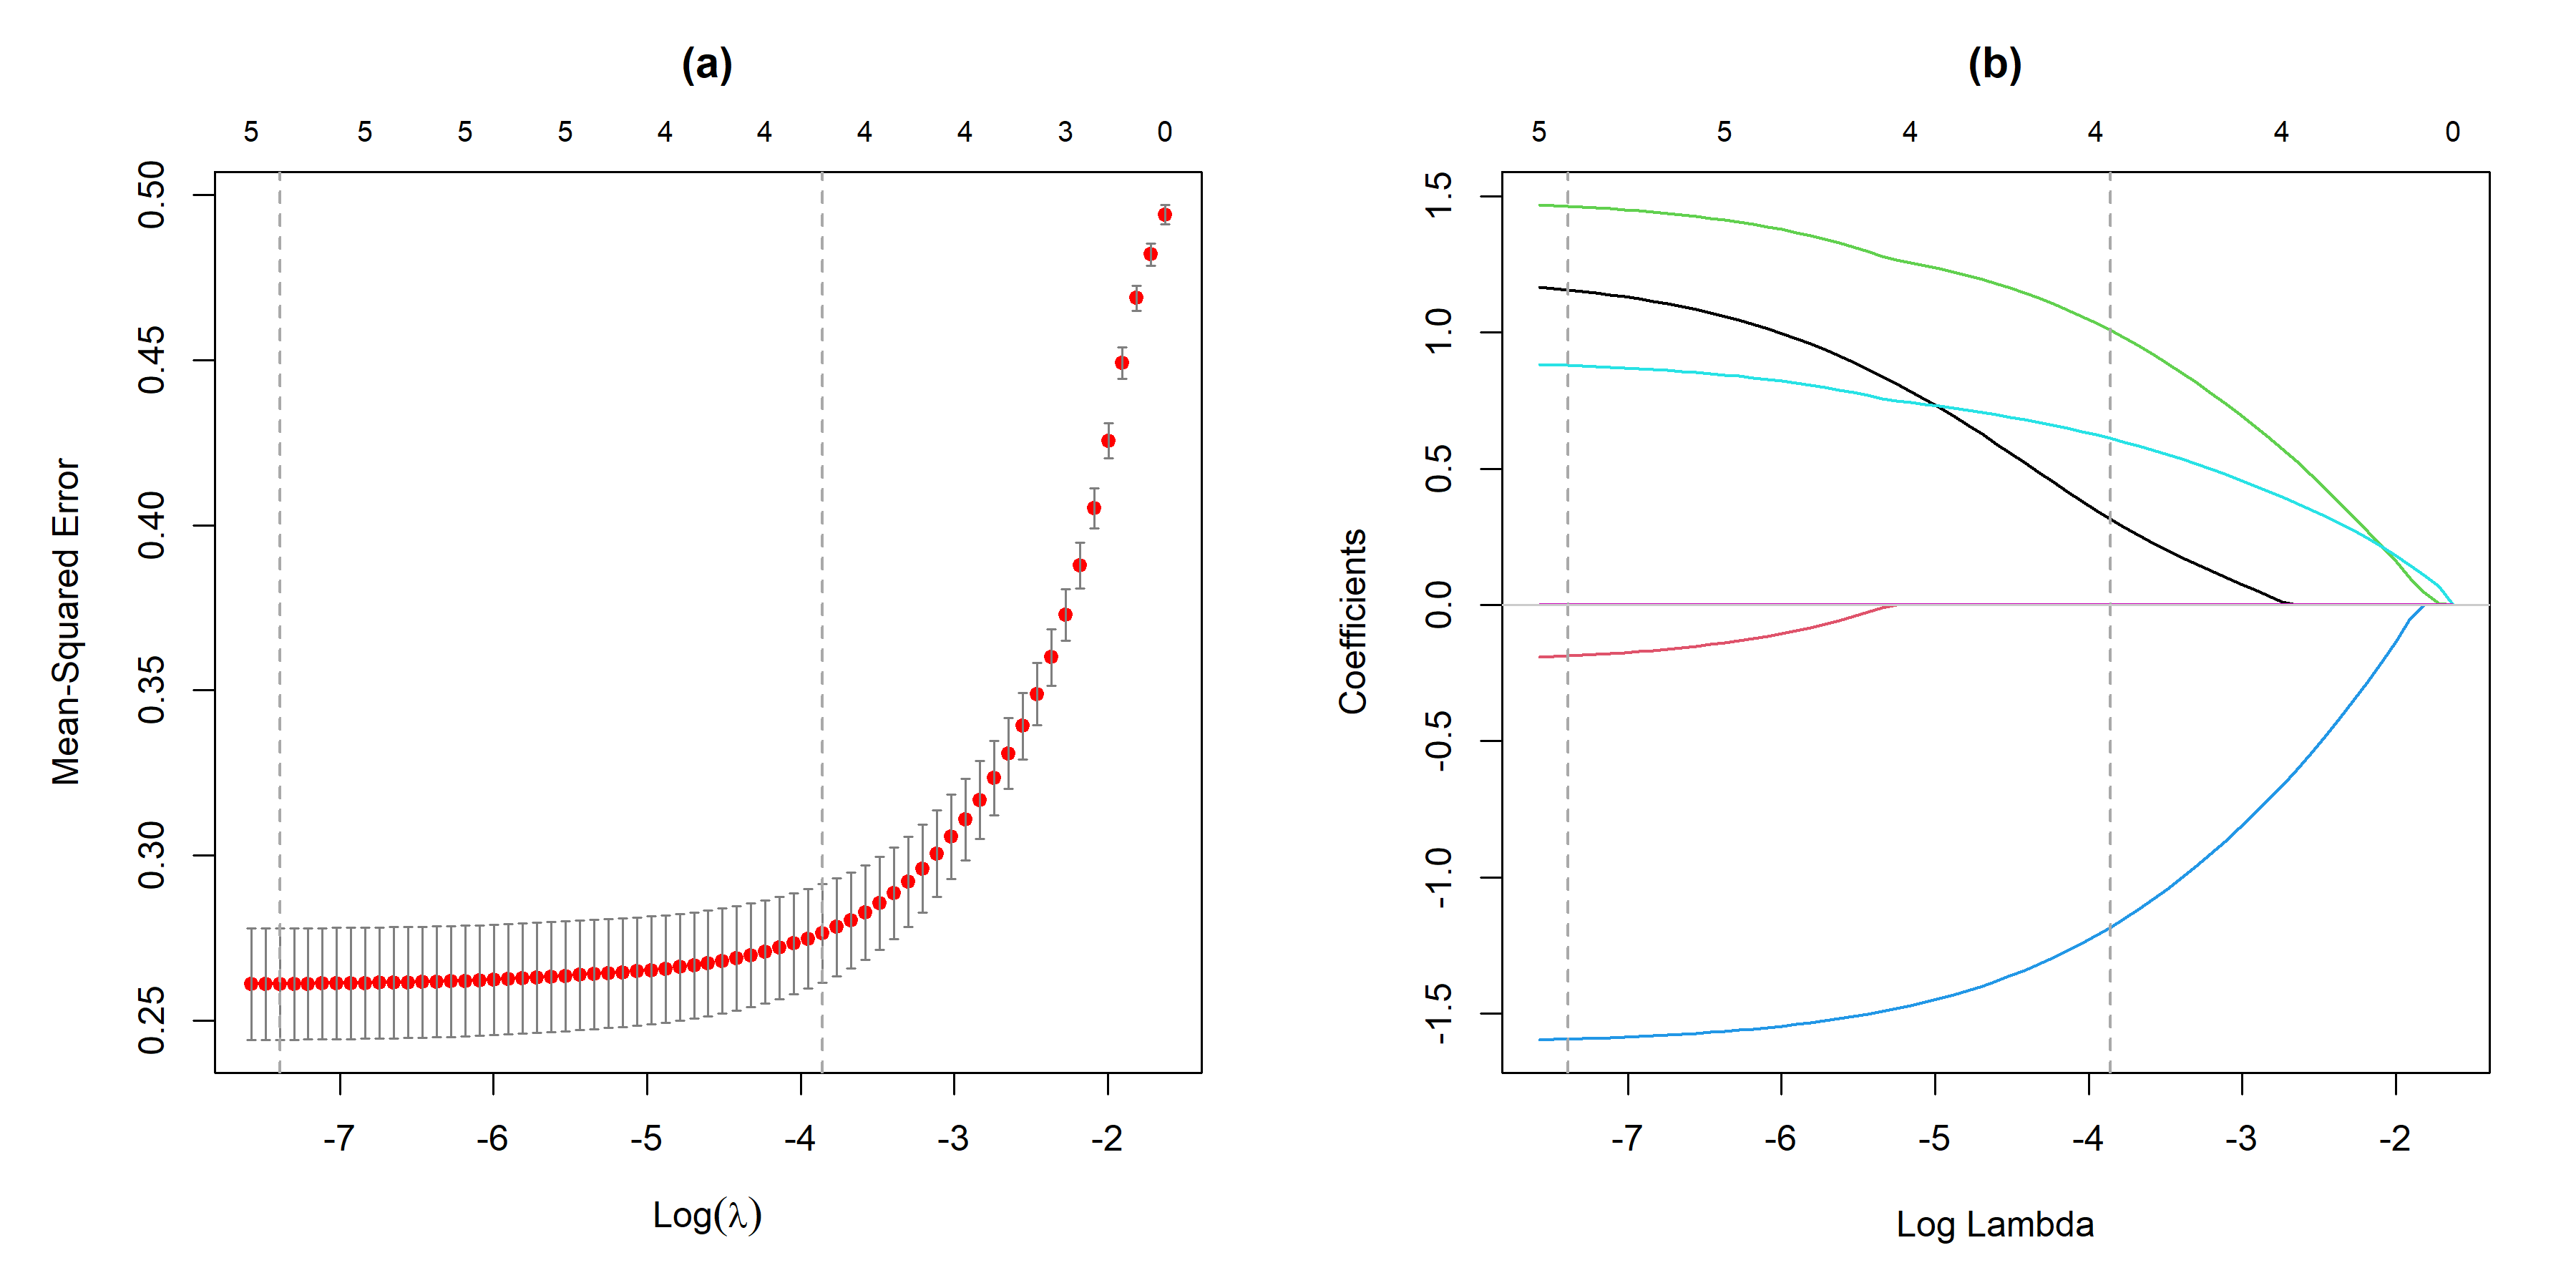

In [49]:
# 显示生成的图表
from IPython.display import Image, display

if os.path.exists("../output/visualisation/LASSO_glmnet.png"):
    print("LASSO回归可视化图表:")
    display(Image(filename="../output/visualisation/LASSO_glmnet.png", width=1000))
else:
    print("图表文件不存在，请检查R脚本是否运行成功")

## 11. 使用R的pROC包绘制平滑ROC曲线

In [50]:
# 创建R脚本绘制原始ROC曲线（训练集+验证集，单调化处理）
r_roc_script = """
library(pROC)

val_predictions <- read.csv("../output/ml_simplified/验证集预测结果_11模型.csv", fileEncoding="UTF-8-BOM")
y_val <- val_predictions[[1]]

train_predictions <- read.csv("../output/ml_simplified/训练集预测结果_11模型.csv", fileEncoding="UTF-8-BOM")
y_train <- train_predictions[[1]]

models <- list(
    list(name="XGBoost", col="XGB_概率", color="#E41A1C"),
    list(name="Logistic", col="GLM_概率", color="#377EB8"),
    list(name="RandomForest", col="RF_概率", color="#FF7F00"),
    list(name="GNB", col="NB_概率", color="#4DAF4A"),
    list(name="SVM", col="SVM_概率", color="#984EA3"),
    list(name="KNN", col="KNN_概率", color="#A65628"),
    list(name="TabPFN", col="TabPFN_概率", color="#FC8D62"),
    list(name="TabM", col="TabM_概率", color="#8DA0CB")
)

# 原始ROC（单调化处理，消除锯齿）
get_roc_raw <- function(y_true, proba) {
    roc_obj <- roc(y_true, proba, quiet=TRUE)
    spec <- roc_obj$specificities
    sens <- roc_obj$sensitivities
    fpr <- 1 - spec
    
    # 排序：FPR升序，相同FPR时TPR降序（取最大TPR）
    ord <- order(fpr, -sens)
    fpr_s <- fpr[ord]
    tpr_s <- sens[ord]
    
    # 单调化：对于相同FPR，只保留最大TPR
    unique_fpr <- unique(fpr_s)
    fpr_final <- numeric(length(unique_fpr))
    tpr_final <- numeric(length(unique_fpr))
    
    for (i in 1:length(unique_fpr)) {
        idx <- which(fpr_s == unique_fpr[i])
        fpr_final[i] <- unique_fpr[i]
        tpr_final[i] <- max(tpr_s[idx])
    }
    
    # 确保单调递增
    for (i in 2:length(tpr_final)) {
        if (tpr_final[i] < tpr_final[i-1]) {
            tpr_final[i] <- tpr_final[i-1]
        }
    }
    
    # 添加起点(0,0)
    list(fpr=c(0, fpr_final), tpr=c(0, tpr_final), roc_obj=roc_obj)
}

# PNG
png("../output/visualisation/ROC_curves_train_val.png", width=4200, height=2100, res=300)
par(mfrow=c(1,2), mar=c(5,5,4,2))

legend_train <- c(); legend_val <- c()
col_train <- c(); col_val <- c()

# 训练集
plot(0, 0, type="n", xlim=c(0,1), ylim=c(0,1),
     xlab="1-Specificity", ylab="Sensitivity", main="ROC curve (Training)")
abline(a=0, b=1, col="#D62728", lty=2, lwd=1.5)

for (m in models) {
    cols <- grep(gsub("_概率", "", m$col), colnames(train_predictions), value=TRUE, ignore.case=TRUE)
    pcol <- cols[grep("概率", cols)]
    if (length(pcol) > 0) {
        proba <- train_predictions[[pcol[1]]]
        if (sum(!is.na(proba)) > 0 && sum(proba != 0) > 0) {
            rd <- get_roc_raw(y_train, proba)
            lines(rd$fpr, rd$tpr, col=m$color, lwd=2)
            ci <- ci.auc(rd$roc_obj, method="bootstrap", boot.n=1000)
            legend_train <- c(legend_train, sprintf("%s (AUC=%.2f 95%%CI %.2f-%.2f)", m$name, auc(rd$roc_obj), ci[1], ci[3]))
            col_train <- c(col_train, m$color)
        }
    }
}
legend("bottomright", legend=legend_train, col=col_train, lwd=2, cex=0.55, bty="n")

# 验证集
plot(0, 0, type="n", xlim=c(0,1), ylim=c(0,1),
     xlab="1-Specificity", ylab="Sensitivity", main="ROC curve (Validation)")
abline(a=0, b=1, col="#D62728", lty=2, lwd=1.5)

for (m in models) {
    cols <- grep(gsub("_概率", "", m$col), colnames(val_predictions), value=TRUE, ignore.case=TRUE)
    pcol <- cols[grep("概率", cols)]
    if (length(pcol) > 0) {
        proba <- val_predictions[[pcol[1]]]
        if (sum(!is.na(proba)) > 0 && sum(proba != 0) > 0) {
            rd <- get_roc_raw(y_val, proba)
            lines(rd$fpr, rd$tpr, col=m$color, lwd=2)
            ci <- ci.auc(rd$roc_obj, method="bootstrap", boot.n=1000)
            legend_val <- c(legend_val, sprintf("%s (AUC=%.2f 95%%CI %.2f-%.2f)", m$name, auc(rd$roc_obj), ci[1], ci[3]))
            col_val <- c(col_val, m$color)
        }
    }
}
legend("bottomright", legend=legend_val, col=col_val, lwd=2, cex=0.55, bty="n")
dev.off()

# PDF
pdf("../output/visualisation/ROC_curves_train_val.pdf", width=14, height=7)
par(mfrow=c(1,2), mar=c(5,5,4,2))

plot(0, 0, type="n", xlim=c(0,1), ylim=c(0,1), xlab="1-Specificity", ylab="Sensitivity", main="ROC curve (Training)")
abline(a=0, b=1, col="#D62728", lty=2, lwd=1.5)
for (m in models) {
    cols <- grep(gsub("_概率", "", m$col), colnames(train_predictions), value=TRUE, ignore.case=TRUE)
    pcol <- cols[grep("概率", cols)]
    if (length(pcol) > 0) {
        proba <- train_predictions[[pcol[1]]]
        if (sum(!is.na(proba)) > 0 && sum(proba != 0) > 0) {
            rd <- get_roc_raw(y_train, proba)
            lines(rd$fpr, rd$tpr, col=m$color, lwd=2)
        }
    }
}
legend("bottomright", legend=legend_train, col=col_train, lwd=2, cex=0.55, bty="n")

plot(0, 0, type="n", xlim=c(0,1), ylim=c(0,1), xlab="1-Specificity", ylab="Sensitivity", main="ROC curve (Validation)")
abline(a=0, b=1, col="#D62728", lty=2, lwd=1.5)
for (m in models) {
    cols <- grep(gsub("_概率", "", m$col), colnames(val_predictions), value=TRUE, ignore.case=TRUE)
    pcol <- cols[grep("概率", cols)]
    if (length(pcol) > 0) {
        proba <- val_predictions[[pcol[1]]]
        if (sum(!is.na(proba)) > 0 && sum(proba != 0) > 0) {
            rd <- get_roc_raw(y_val, proba)
            lines(rd$fpr, rd$tpr, col=m$color, lwd=2)
        }
    }
}
legend("bottomright", legend=legend_val, col=col_val, lwd=2, cex=0.55, bty="n")
dev.off()

cat("\\n完成! 训练集和验证集ROC曲线（单调化处理）\\n")
"""

with open("../output/visualisation/roc_smooth.R", "w", encoding="utf-8") as f:
    f.write(r_roc_script)

print("R脚本已更新：原始ROC曲线（单调化处理，消除锯齿）")

R脚本已更新：原始ROC曲线（单调化处理，消除锯齿）


In [51]:
# 运行平滑ROC曲线R脚本
print("=" * 70)
print("使用R的pROC包绘制平滑ROC曲线")
print("=" * 70)

result = subprocess.run(
    [R_EXE, "../output/visualisation/roc_smooth.R"],
    capture_output=True,
    text=True,
    timeout=300,
    cwd=os.getcwd(),
)

print(result.stdout)

if result.returncode != 0:
    print("错误信息:")
    print(result.stderr)
else:
    print("=" * 70)
    print("平滑ROC曲线生成完成！")
    print("=" * 70)

使用R的pROC包绘制平滑ROC曲线

Hi, Dr_shen, Welcome at Sun Dec 28 14:20:21 2025 
null device 
          1 
null device 
          1 

完成! 训练集和验证集ROC曲线（单调化处理）

Goodbye, Dr_shen, Sun Dec 28 14:20:26 2025 

平滑ROC曲线生成完成！


ROC曲线（训练集+验证集）:


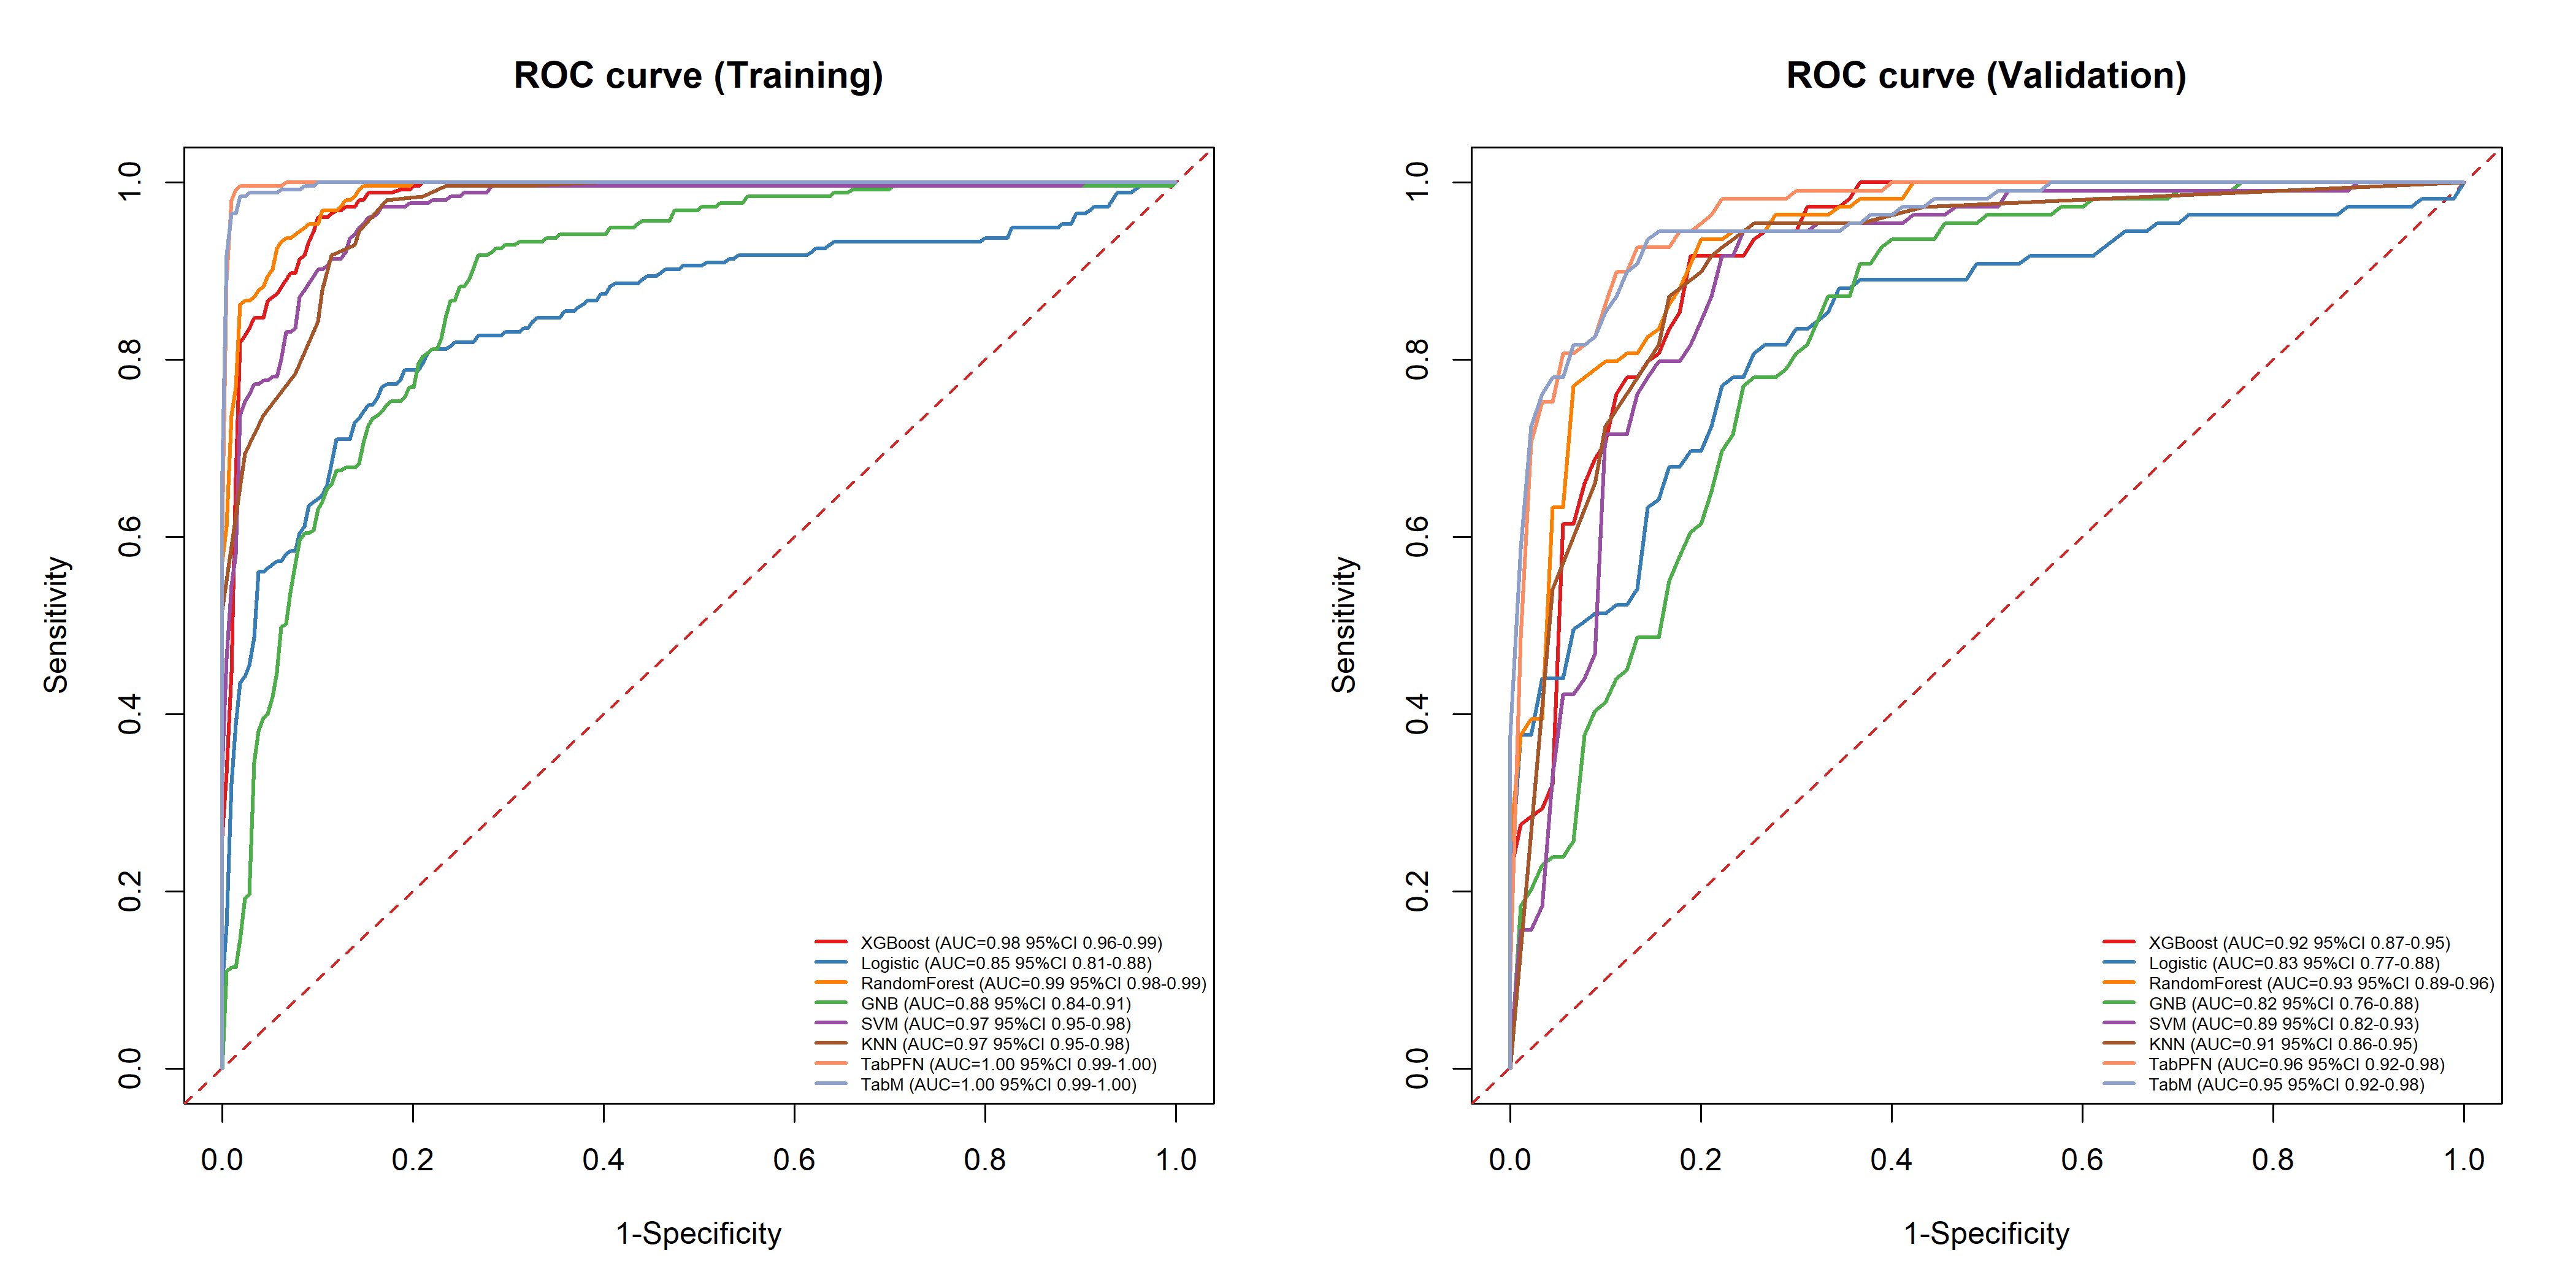

In [52]:
# 显示ROC曲线图表（训练集+验证集）
from IPython.display import Image, display

if os.path.exists("../output/visualisation/ROC_curves_train_val.png"):
    print("ROC曲线（训练集+验证集）:")
    display(
        Image(filename="../output/visualisation/ROC_curves_train_val.png", width=1000)
    )
else:
    print("图表文件不存在，请检查R脚本是否运行成功")